Support Win Rate: 54.10% (Signals: 61)
Resistance Win Rate: 63.93% (Signals: 61)


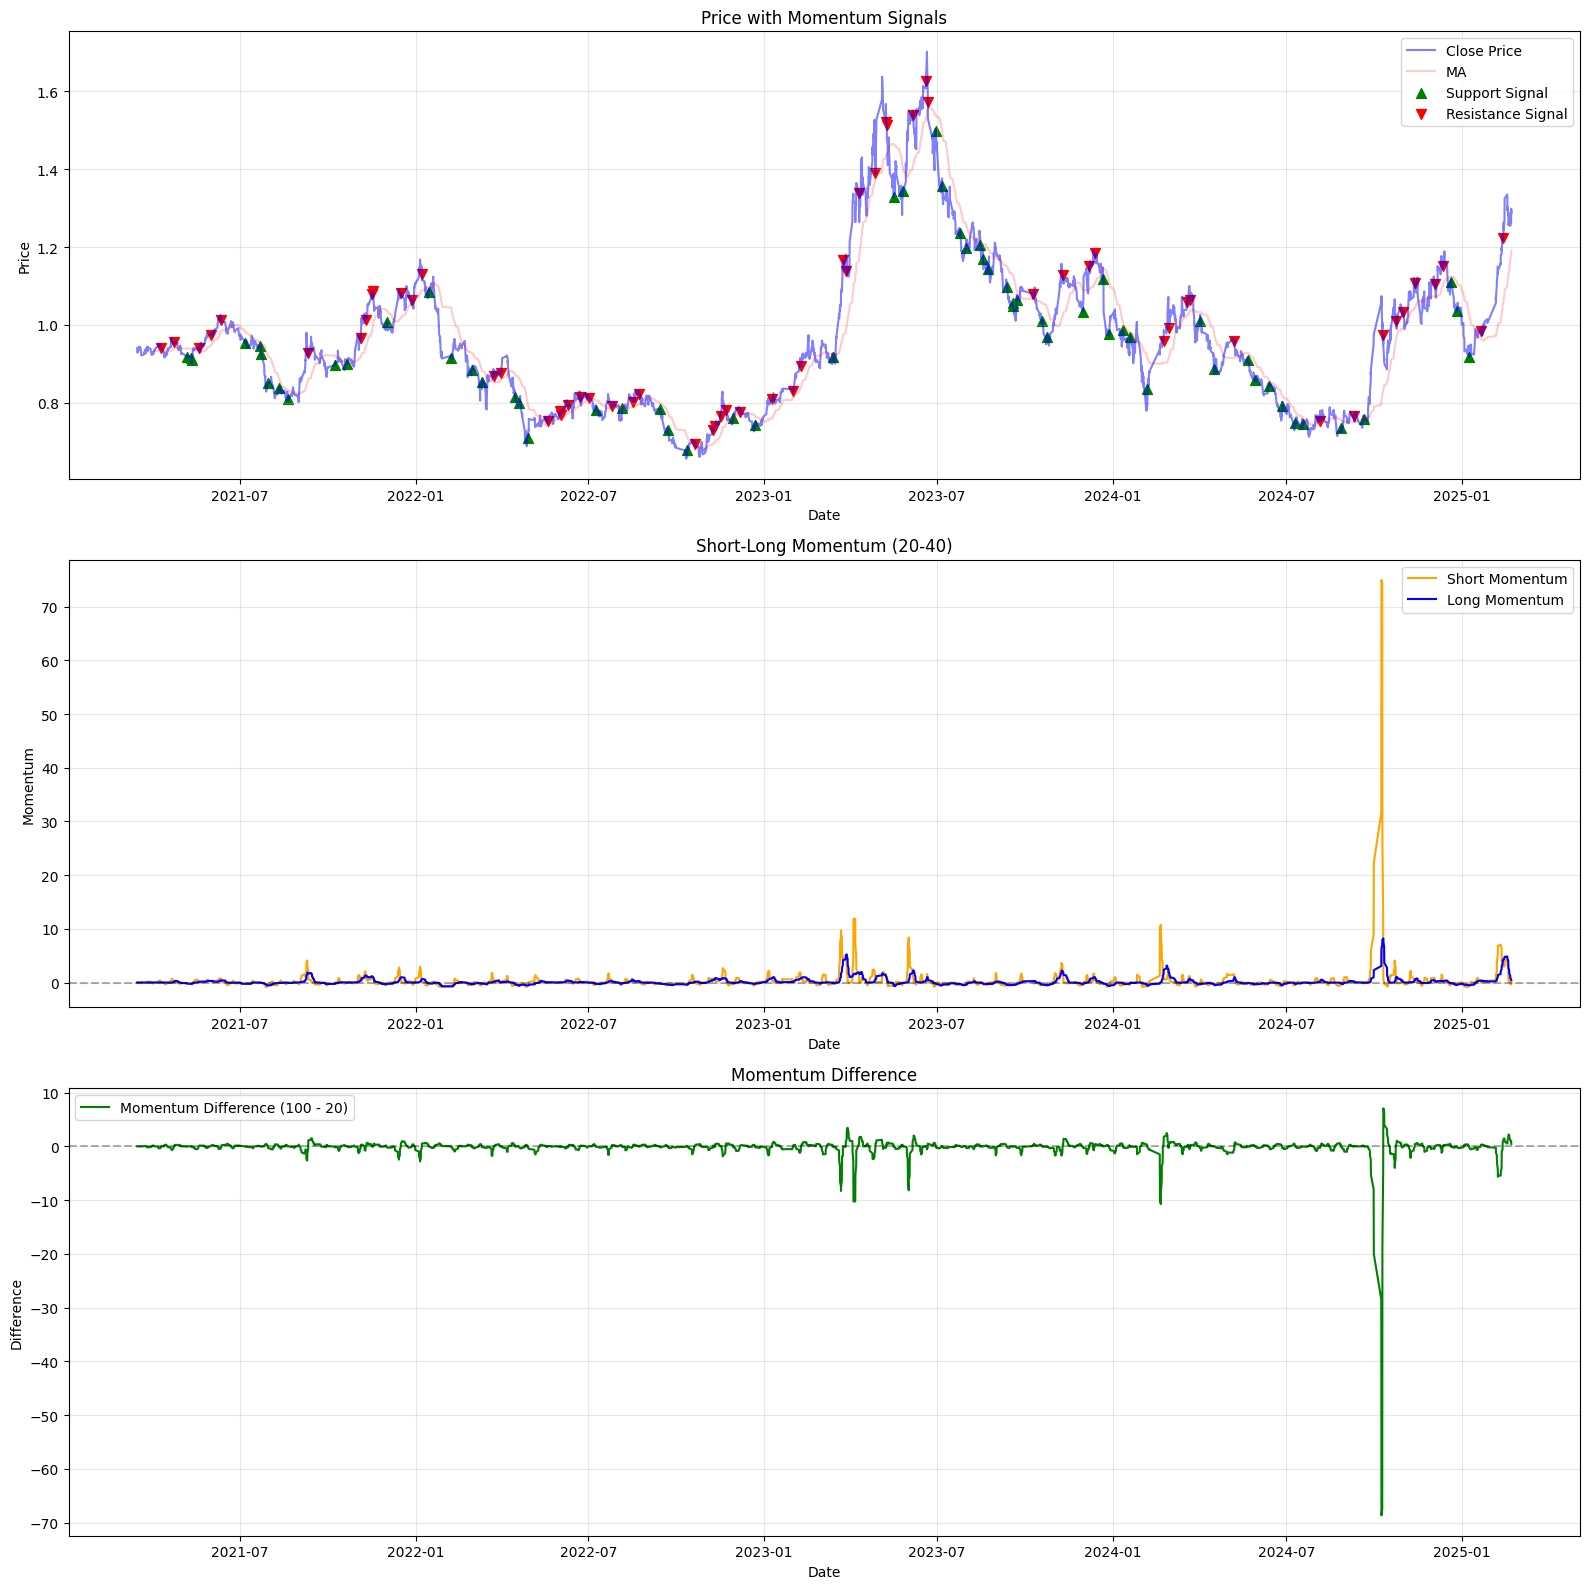

In [ ]:
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# 假设已有 ATR 和 get_future_range_numba 函数
def ATR(high, low, close, period=14):
    tr = pd.DataFrame(index=high.index)
    tr['HL'] = high - low
    tr['HC'] = abs(high - close.shift(1))
    tr['LC'] = abs(low - close.shift(1))
    tr['TR'] = tr[['HL', 'HC', 'LC']].max(axis=1)
    return tr['TR'].rolling(window=int(period), min_periods=1).mean()

@njit
def get_future_range_numba(series, look_ahead, is_high=True):
    future_values = np.full(len(series), np.nan)
    for i in range(len(series) - look_ahead):
        if is_high:
            future_values[i] = np.max(series[i+1:i+1+look_ahead])
        else:
            future_values[i] = np.min(series[i+1:i+1+look_ahead])
    return future_values

# 数据文件路径
data_dir = '../data'
csv_filename = 'data_159869_XSHE_2021-03-15_2025-02-24_60m.csv'
csv_path = os.path.join(data_dir, csv_filename)
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

def calc_momentum(close: pd.Series, N=21, method='linear')->pd.Series:
    """
    计算动量因子序列
    返回一个包含所有时间点动量值的Series
    """
    result = pd.Series(index=close.index, dtype=float)
    
    # 对于每个时间点，计算从该点往前N个周期的动量
    for i in range(N-1, len(close)):
        price = close.iloc[i-N+1:i+1].tolist()
        y = np.log(price)
        x = np.arange(len(y))
        if method == 'linear':
            slope, intercept = np.polyfit(x, y, 1)
            annualized_returns = math.pow(math.exp(slope), 250) - 1
            r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
            score = annualized_returns * r_squared
        elif method == 'polynomial':
            slope_list = np.polyfit(x, y, 2)
            annualized_returns = math.pow(math.exp(slope_list[1]), 250) - 1
            y_predict = np.polyval(slope_list,x)
            r_squared = 1 - (sum((y-y_predict)**2) / ((len(y) - 1) * np.var(y, ddof=1)))
            score = annualized_returns * r_squared
        else:
            raise ValueError(f"Unsupported method: {method}")
            
        result.iloc[i] = score
    
    # 填充前N-1个位置为NaN
    result.iloc[:N-1] = np.nan
    
    return result

# 计算动量
def calculate_momentum(df, window_short=20, window_long=40):
    momentum_short = calc_momentum(df['close'],window_short).fillna(0)
    momentum_long = calc_momentum(df['close'],window_long).fillna(0)
    momentum_diff = momentum_long - momentum_short
    return momentum_short, momentum_long, momentum_diff

window_short = 20
window_long = 40
ma_window = 60

momentum_short, momentum_long, momentum_diff = calculate_momentum(df, window_short, window_long)

# 生成信号
def generate_signals(df, momentum_short, momentum_long, ma_window, look_ahead=10, target_multiplier=1.0, atr_period=20):
    df = df.copy()
    df['ma'] = df['close'].rolling(window=ma_window).mean()
    atr = ATR(df['high'], df['low'], df['close'], period=atr_period)
    df['support_target'] = df['close'] + atr * target_multiplier
    df['resistance_target'] = df['close'] - atr * target_multiplier
    
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)

    # df['support_condition'] = (momentum_long < momentum_short) & (momentum_long.shift(1) >= momentum_short.shift(1))
    # df['resistance_condition'] = (momentum_long > momentum_short) & (momentum_long.shift(1) <= momentum_short.shift(1))
    
    df['support_condition'] = (df['ma'] >= df['close']) & (momentum_long < momentum_short) & (momentum_long.shift(1) >= momentum_short.shift(1))
    df['resistance_condition'] = (df['ma'] <= df['close']) & (momentum_long > momentum_short) & (momentum_long.shift(1) <= momentum_short.shift(1))

    # df['support_condition'] = (ma > df['close']) & (momentum_short.shift(1) < momentum_short) & (momentum_long >= momentum_long.shift(1)) & (momentum_long.shift(1) <= momentum_long.shift(2))
    # df['resistance_condition'] = (ma < df['close']) & (momentum_short.shift(1) > momentum_short) & (momentum_long <= momentum_long.shift(1)) & (momentum_long.shift(1) >= momentum_long.shift(2))
    
    df['reversal'] = np.select(
        [df['support_condition'], df['resistance_condition']],
        ['support reversal', 'resistance reversal'],
        default='none'
    )
    
    df['support_win'] = (df['reversal'] == 'support reversal') & (df['future_high'] >= df['support_target']).astype(int)
    df['resistance_win'] = (df['reversal'] == 'resistance reversal') & (df['future_low'] <= df['resistance_target']).astype(int)
    return df

df_with_signals = generate_signals(df, momentum_short, momentum_long, ma_window=ma_window, look_ahead=10, target_multiplier=1.0, atr_period=20)

def plot_momentum_signals(df, df_with_signals, window_short=60, window_long=100):
    # 绘制图表
    plt.figure(figsize=(16, 16))

    # 主图：收盘价 + 信号
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['close'], label='Close Price', color='blue', alpha=0.5)
    plt.plot(df.index, df_with_signals['ma'], label='MA', color='red', alpha=0.2)
    support_signals = df_with_signals[df_with_signals['reversal'] == 'support reversal']
    resistance_signals = df_with_signals[df_with_signals['reversal'] == 'resistance reversal']
    plt.scatter(support_signals.index, support_signals['close'], color='green', label='Support Signal', marker='^', s=50)
    plt.scatter(resistance_signals.index, resistance_signals['close'], color='red', label='Resistance Signal', marker='v', s=50)
    plt.title('Price with Momentum Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 子图 1：动量
    plt.subplot(3, 1, 2)
    plt.plot(df.index, momentum_short, label='Short Momentum', color='orange')
    plt.plot(df.index, momentum_long, label='Long Momentum', color='blue')
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.title(f'Short-Long Momentum ({window_short}-{window_long})')
    plt.xlabel('Date')
    plt.ylabel('Momentum')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 子图 2：动量差异
    plt.subplot(3, 1, 3)
    plt.plot(df.index, momentum_diff, label='Momentum Difference (100 - 20)', color='green')
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.title('Momentum Difference')
    plt.xlabel('Date')
    plt.ylabel('Difference')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 简单性能评估
def evaluate_performance(df):
    support_signals = df[df['reversal'] == 'support reversal']
    resistance_signals = df[df['reversal'] == 'resistance reversal']
    support_win_rate = support_signals['support_win'].mean() if len(support_signals) > 0 else 0
    resistance_win_rate = resistance_signals['resistance_win'].mean() if len(resistance_signals) > 0 else 0
    print(f"Support Win Rate: {support_win_rate:.2%} (Signals: {len(support_signals)})")
    print(f"Resistance Win Rate: {resistance_win_rate:.2%} (Signals: {len(resistance_signals)})")

evaluate_performance(df_with_signals)
plot_momentum_signals(df, df_with_signals,window_short=window_short, window_long=window_long)

In [ ]:
import itertools

# 优化函数
def optimize_parameters(df, window_short_range, window_long_range, ma_window_range, min_signals=20, w1=0.5, w2=0.5, lambda_penalty=0.01):
    best_objective = -np.inf
    best_params = None
    
    for window_short, window_long, ma_window in itertools.product(window_short_range, window_long_range, ma_window_range):
        if window_short >= window_long:
            continue
        
        # 计算动量和信号
        momentum_short, momentum_long, _ = calculate_momentum(df, window_short, window_long)
        df_with_signals = generate_signals(df, momentum_short, momentum_long, ma_window)
        
        # 提取支撑和阻力信号
        support_signals = df_with_signals[df_with_signals['reversal'] == 'support reversal']
        resistance_signals = df_with_signals[df_with_signals['reversal'] == 'resistance reversal']
        
        num_support_signals = len(support_signals)
        num_resistance_signals = len(resistance_signals)
        
        # 计算惩罚项
        if num_support_signals < min_signals or num_resistance_signals < min_signals:
            penalty = lambda_penalty * (2 * min_signals - num_support_signals - num_resistance_signals)
        else:
            penalty = 0
        
        # 计算胜率
        support_win_rate = support_signals['support_win'].mean() if num_support_signals > 0 else 0
        resistance_win_rate = resistance_signals['resistance_win'].mean() if num_resistance_signals > 0 else 0
        
        # 计算目标值
        objective = w1 * support_win_rate + w2 * resistance_win_rate - penalty
        
        # 更新最佳参数
        if objective > best_objective:
            best_objective = objective
            best_params = (window_short, window_long, ma_window)
            print(f"New best: window_short={window_short}, window_long={window_long}, ma_window={ma_window}, objective={objective:.4f}, "
                  f"support_win_rate={support_win_rate:.2%}, resistance_win_rate={resistance_win_rate:.2%}, "
                  f"support_signals={num_support_signals}, resistance_signals={num_resistance_signals}")
    
    return best_params, best_objective

# 定义参数范围
window_short_range = range(5, 30, 5)
window_long_range = range(15, 60, 5)
ma_window_range = range(10, 100, 10)

# 运行优化
min_signals = len(df) * 0.02
best_params, best_objective = optimize_parameters(df, window_short_range, window_long_range, ma_window_range, min_signals=min_signals)

# 输出结果
print(f"\n优化完成！{min_signals}")
print(f"最佳参数: window_short={best_params[0]}, window_long={best_params[1]}, ma_window={best_params[2]}")
print(f"最佳目标值: {best_objective:.4f}")

# 使用最佳参数生成信号并评估
momentum_short, momentum_long, _ = calculate_momentum(df, best_params[0], best_params[1])
df_with_signals = generate_signals(df, momentum_short, momentum_long, best_params[2])

support_signals = df_with_signals[df_with_signals['reversal'] == 'support reversal']
resistance_signals = df_with_signals[df_with_signals['reversal'] == 'resistance reversal']
support_win_rate = support_signals['support_win'].mean() if len(support_signals) > 0 else 0
resistance_win_rate = resistance_signals['resistance_win'].mean() if len(resistance_signals) > 0 else 0

print(f"最佳参数性能评估：")
evaluate_performance(df_with_signals)
plot_momentum_signals(df, df_with_signals,window_short=best_params[0], window_long=best_params[1])

New best: window_short=5, window_long=15, ma_window=10, objective=0.6255, support_win_rate=61.86%, resistance_win_rate=63.24%, support_signals=194, resistance_signals=185
New best: window_short=5, window_long=15, ma_window=30, objective=0.6299, support_win_rate=63.08%, resistance_win_rate=62.90%, support_signals=195, resistance_signals=186
New best: window_short=5, window_long=15, ma_window=50, objective=0.6333, support_win_rate=64.09%, resistance_win_rate=62.57%, support_signals=181, resistance_signals=187
New best: window_short=5, window_long=20, ma_window=10, objective=0.6515, support_win_rate=63.43%, resistance_win_rate=66.87%, support_signals=175, resistance_signals=166
New best: window_short=5, window_long=20, ma_window=30, objective=0.6529, support_win_rate=65.17%, resistance_win_rate=65.41%, support_signals=178, resistance_signals=185
New best: window_short=10, window_long=20, ma_window=10, objective=0.7325, support_win_rate=64.13%, resistance_win_rate=61.97%, support_signals=9